# Chris McCormick - BERT Word Embeddings Tutorial
http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/

In [1]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


UsageError: Line magic function `%` not found.


In [2]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
list(tokenizer.vocab.keys())[5000:5020]

['knight',
 'lap',
 'survey',
 'ma',
 '##ow',
 'noise',
 'billy',
 '##ium',
 'shooting',
 'guide',
 'bedroom',
 'priest',
 'resistance',
 'motor',
 'homes',
 'sounded',
 'giant',
 '##mer',
 '150',
 'scenes']

In [11]:
text = "After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank."
marked_text = "[CLS] " + text + " [SEP]"
print('marked text:')
print (marked_text)

tokenized_text = tokenizer.tokenize(marked_text)
print('\ntokens:')
print (tokenized_text)

indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
print('\ntokens index:')
print([tup for tup in zip(tokenized_text, indexed_tokens)])

segments_ids = [1] * len(tokenized_text)
print('sergments:', segments_ids)

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

marked text:
[CLS] After stealing money from the bank vault, the bank robber was seen fishing on the Mississippi river bank. [SEP]

tokens:
['[', 'cl', '##s', ']', 'after', 'stealing', 'money', 'from', 'the', 'bank', 'vault', ',', 'the', 'bank', 'robber', 'was', 'seen', 'fishing', 'on', 'the', 'mississippi', 'river', 'bank', '.', '[', 'sep', ']']

tokens index:
[('[', 1031), ('cl', 18856), ('##s', 2015), (']', 1033), ('after', 2044), ('stealing', 11065), ('money', 2769), ('from', 2013), ('the', 1996), ('bank', 2924), ('vault', 11632), (',', 1010), ('the', 1996), ('bank', 2924), ('robber', 27307), ('was', 2001), ('seen', 2464), ('fishing', 5645), ('on', 2006), ('the', 1996), ('mississippi', 5900), ('river', 2314), ('bank', 2924), ('.', 1012), ('[', 1031), ('sep', 19802), (']', 1033)]
sergments: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Model

In [14]:
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

100%|██████████| 407873900/407873900 [00:16<00:00, 24195266.91B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
        )

In [15]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)

In [25]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 27
Number of hidden units: 768


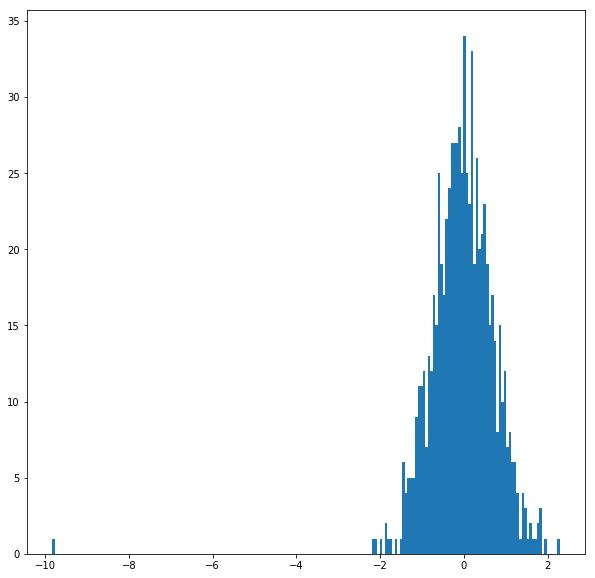

In [24]:
# For the 5th token in our sentence, select its feature values from layer 5.
batch_i = 0
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

In [26]:
# Convert the hidden state embeddings into single token vectors

# Holds the list of 12 layer embeddings for each token
# Will have the shape: [# tokens, # layers, # features]
token_embeddings = [] 

# For each token in the sentence...
for token_i in range(len(tokenized_text)):
  
  # Holds 12 layers of hidden states for each token 
  hidden_layers = [] 
  
  # For each of the 12 layers...
  for layer_i in range(len(encoded_layers)):
    
    # Lookup the vector for `token_i` in `layer_i`
    vec = encoded_layers[layer_i][batch_i][token_i]
    
    hidden_layers.append(vec)
    
  token_embeddings.append(hidden_layers)

# Sanity check the dimensions:
print ("Number of tokens in sequence:", len(token_embeddings))
print ("Number of layers per token:", len(token_embeddings[0]))

Number of tokens in sequence: 27
Number of layers per token: 12


In [30]:
# Word vectors example:
concatenated_last_4_layers = [torch.cat((layer[-1], layer[-2], layer[-3], layer[-4]), 0) for layer in token_embeddings] # [number_of_tokens, 3072]
summed_last_4_layers = [torch.sum(torch.stack(layer)[-4:], 0) for layer in token_embeddings] # [number_of_tokens, 768]

In [31]:
# Sentence embedding example:
sentence_embedding = torch.mean(encoded_layers[11], 1)
print ("Our final sentence embedding vector of shape:"), sentence_embedding[0].shape[0]

Our final sentence embedding vector of shape:


(None, 768)